https://github.com/pymc-devs/pymc3/pull/2876

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pylab as plt

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Cherry picked old commit

In [2]:
from pymc3.model import modelcontext, get_named_nodes_and_relations
from pymc3.util import is_transformed_name, get_untransformed_name
from tqdm import tqdm


def sample_prior(samples=500, model=None, vars=None, size=None,
                 random_seed=None, progressbar=True):
    """Generate samples from the prior of a model.

    Parameters
    ----------
    samples : int
        Number of samples from the prior to generate. Defaults to 500.
    model : Model (optional if in `with` context)
    vars : iterable
        Variables for which to compute the posterior predictive samples.
        Defaults to `model.named_vars`.
    size : int
        The number of random draws from the distribution specified by the
        parameters in each sample of the trace.
    random_seed : int
        Seed for the random number generator.
    progressbar : bool
        Whether or not to display a progress bar in the command line.

    Returns
    -------
    dict
        Dictionary with the variables as keys. The values are arrays of prior samples.
    """

    model = modelcontext(model)

    if vars is None:
        vars = set(model.named_vars.keys())

    if random_seed is not None:
        np.random.seed(random_seed)

    if progressbar:
        indices = tqdm(range(samples))

    def step(model):
        point = {}
        for var in model.basic_RVs:
            var_name = var.name
            if hasattr(var, 'distribution'):
                if is_transformed_name(var_name):
                    val = var.distribution.dist.random(
                        point=point, size=size)
                    var_name_untranf = get_untransformed_name(var_name)
                    point[var_name_untranf] = val
                    val = var.distribution.transform_used.forward_val(val)
                else:
                    val = var.distribution.random(point=point, size=size)
            else:
                nn, _, _ = get_named_nodes_and_relations(var)
                val = var.eval({model.named_vars[v]: point[v]
                                for v in nn})

            point[var_name] = val
        return point

    try:
        prior = {var: [] for var in vars}
        for _ in indices:
            point = step(model)
            for var_name, var in model.named_vars.items():
                if var_name in vars:
                    if var_name in point:
                        val = point[var_name]
                    else:
                        nn, _, _ = get_named_nodes_and_relations(var)
                        val = var.eval({model.named_vars[v]: point[v]
                                        for v in nn})
                    prior[var_name].append(val)

    except KeyboardInterrupt:
        pass

    finally:
        if progressbar:
            indices.close()

    return {k: np.asarray(v) for k, v in prior.items()}

In [3]:
observed = np.random.normal(10, 1, size=200)
with pm.Model() as m: 
    # Use a prior that's way off to show we're actually sampling from it 
    mu = pm.Normal('mu', mu=-10, sd=1) 
    positive_mu = pm.Deterministic('positive_mu', np.abs(mu)) 
    pm.Normal('x_obs', mu=mu, sd=1, observed=observed) 
    prior = sample_prior() 

assert (prior['mu'] < 0).all() 
assert (prior['positive_mu'] > 0).all() 
assert (prior['x_obs'] < 0).all()

100%|██████████| 500/500 [00:00<00:00, 1499.66it/s]


## More complex example

In [4]:
data = pd.read_table(pm.get_data('efron-morris-75-data.tsv'), sep="\t")
at_bats, hits = data[['At-Bats', 'Hits']].values.T
N = len(hits)

### Reference numpy implementation

In [5]:
import scipy.stats as stats

In [6]:
def model_prior_sample(nsample):
    phi = stats.beta.rvs(1., 1., size=nsample)
    logkappa = np.random.exponential(1/5., nsample)
    kappa = np.exp(logkappa)
    thetas = stats.beta.rvs(phi*kappa, (1.-phi)*kappa, size=(N, nsample))
    y = stats.binom.rvs(n=at_bats[:, None], p=thetas)
    
    psample = {}
    psample['phi'] = phi
    psample['logkappa'] = logkappa
    psample['kappa'] = kappa
    psample['thetas'] = thetas.T
    psample['y'] = y.T
    return psample

In [7]:
%%time

psample0 = model_prior_sample(10000)

CPU times: user 98.7 ms, sys: 15.8 ms, total: 115 ms
Wall time: 158 ms


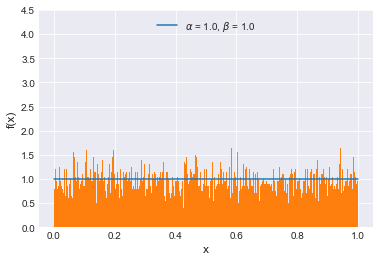

In [8]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 1, 200)
a = 1.
b = 1.
pdf = stats.beta.pdf(x, a, b)
plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.hist(psample0['phi'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

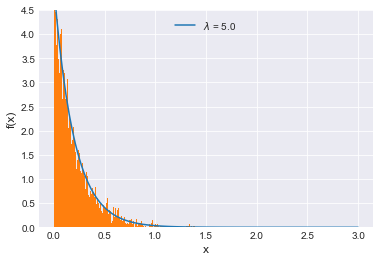

In [9]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 3, 100)
lam = 5.
pdf = stats.expon.pdf(x, scale=1.0/lam)
plt.plot(x, pdf, label=r'$\lambda$ = {}'.format(lam))
plt.hist(psample0['logkappa'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

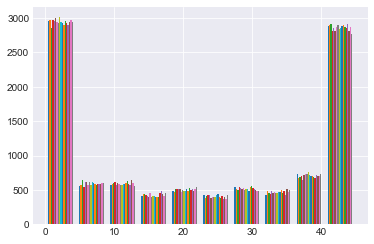

In [10]:
plt.hist(psample0['y']);

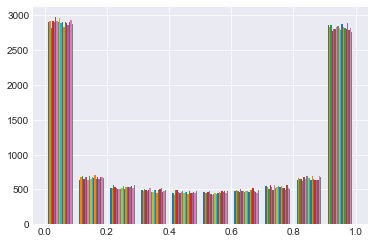

In [11]:
plt.hist(psample0['thetas']);

In [12]:
psample0['thetas'].mean(axis=0) * at_bats

array([22.41896298, 22.32233629, 22.44703146, 22.17265024, 22.20582192,
       22.08917145, 22.37103113, 22.39681344, 22.23881235, 22.2582037 ,
       22.37424149, 22.50362433, 22.29571719, 22.26736356, 22.43167679,
       22.242809  , 22.21473573, 22.18444638])

In [13]:
psample0['y'].mean(axis=0)

array([22.4234, 22.3325, 22.4429, 22.1589, 22.1886, 22.0825, 22.3586,
       22.4301, 22.2507, 22.2649, 22.3785, 22.4985, 22.2797, 22.2657,
       22.4343, 22.2139, 22.1971, 22.1776])

### Check old implementation

In [14]:
with pm.Model() as model:
    phi = pm.Beta('phi', alpha=1., beta=1.)

    kappa_log = pm.Exponential('logkappa', lam=5.)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta('thetas', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=N)

    y = pm.Binomial('y', n=at_bats, p=thetas, shape=N, observed=hits)

In [15]:
y.distribution.random(point=model.test_point, size=1000)

array([[22, 43,  6, ..., 10,  5, 12],
       [ 4, 42, 32, ..., 14,  0, 15],
       [20,  2,  8, ..., 39, 45, 20],
       ...,
       [43,  2, 40, ...,  0,  0, 23],
       [27, 27, 14, ..., 26,  2, 19],
       [31, 16,  3, ..., 13, 19, 18]])

In [16]:
np.random.binomial(45, thetas.tag.test_value, size=(1000, N))

array([[24, 28, 20, ..., 26, 25, 23],
       [24, 24, 25, ..., 23, 26, 23],
       [22, 21, 16, ..., 18, 21, 27],
       ...,
       [26, 16, 26, ..., 26, 20, 26],
       [26, 25, 20, ..., 24, 28, 27],
       [28, 21, 30, ..., 24, 18, 23]])

In [17]:
# names = ['phi', 'kappa_log', 'kappa', 'thetas', 'y']
# values = pm.distributions.draw_values([model[name] for name in names], size=100)
# p = {k: v for k, v in zip(names, values)}

In [18]:
%%time
psample1 = sample_prior(10000, model=model)

100%|██████████| 10000/10000 [00:17<00:00, 583.58it/s]


CPU times: user 15.7 s, sys: 485 ms, total: 16.2 s
Wall time: 17.4 s


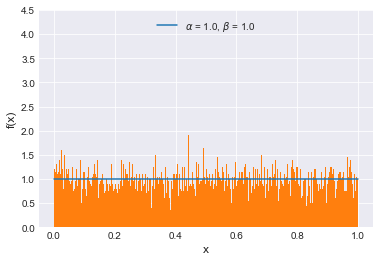

In [19]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 1, 200)
a = 1.
b = 1.
pdf = stats.beta.pdf(x, a, b)
plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.hist(psample1['phi'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

In [20]:
np.min(psample1['phi']), np.max(psample1['phi'])

(0.0001501463319386596, 0.999876326487962)

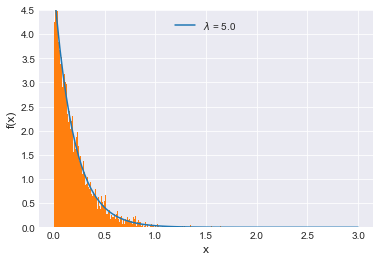

In [21]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 3, 100)
lam = 5.
pdf = stats.expon.pdf(x, scale=1.0/lam)
plt.plot(x, pdf, label=r'$\lambda$ = {}'.format(lam))
plt.hist(psample1['logkappa'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

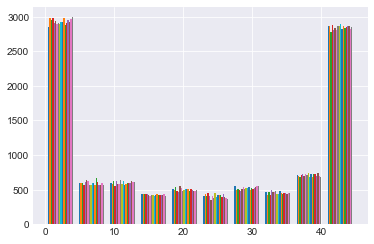

In [22]:
plt.hist(psample1['y']);

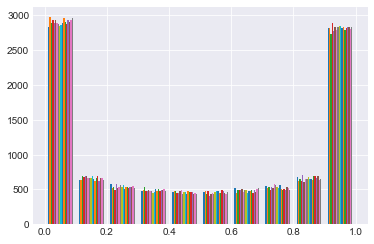

In [23]:
plt.hist(psample1['thetas']);

In [24]:
psample1['thetas'].mean(axis=0) * at_bats

array([22.49724718, 22.12291204, 22.02591433, 22.30218004, 22.23885308,
       22.13546889, 22.28287446, 22.36668279, 22.50449873, 22.35215582,
       22.36319925, 22.18929015, 22.22887664, 22.33192974, 22.30861238,
       22.39341846, 22.10039603, 22.17825385])

In [25]:
psample1['y'].mean(axis=0)

array([22.517 , 22.13  , 21.9989, 22.2978, 22.2545, 22.1283, 22.2688,
       22.3979, 22.4823, 22.3497, 22.347 , 22.1705, 22.2446, 22.329 ,
       22.3095, 22.388 , 22.0841, 22.152 ])

### Check new implementation

In [26]:
from pymc3.distributions.distribution import draw_values

with pm.Model() as m:
    p = pm.Beta('p', 1., 1.)
draw_values([m['p']], size=10)

[array([0.99792629, 0.08433805, 0.90384697, 0.80169345, 0.43326917,
        0.27544793, 0.19031141, 0.84730342, 0.00771045, 0.12660012])]

In [28]:
import theano

X = theano.shared(np.arange(3))
with pm.Model() as m:
    ind = pm.Categorical('i', np.ones(3)/3)
    x = pm.Deterministic('X', X[ind])
prior = pm.sample_prior_predictive(10, model=m)

In [29]:
prior

{'X': array([0, 0, 2, 2, 1, 2, 0, 1, 2, 0]),
 'i': array([0, 0, 2, 2, 1, 2, 0, 1, 2, 0])}

In [30]:
with pm.Model() as m:
    p = pm.Beta('p', 1., 1.)
    n = pm.DiscreteUniform('n', 5, 20)
    y = pm.Binomial('y', n, p, observed=5)
    prior = pm.sample_prior_predictive(10)
prior

{'n': array([ 6, 11, 18,  8, 20, 10, 13,  5, 11, 10]),
 'p': array([0.65844113, 0.73591502, 0.06806071, 0.86415054, 0.15636394,
        0.70507994, 0.61979741, 0.57661783, 0.13302441, 0.90292   ]),
 'p_logodds__': array([ 0.65635508,  1.02484371, -2.61686763,  1.85019962, -1.68553494,
         0.87160687,  0.48868843,  0.30890448, -1.87447813,  2.23009862]),
 'y': array([ 0,  2,  1,  0, 17,  4,  3,  6,  6,  6])}

In [31]:
with pm.Model() as model:
    phi = pm.Beta('phi', alpha=1., beta=1.)

    kappa_log = pm.Exponential('logkappa', lam=5.)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta('thetas', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=N)

    y = pm.Binomial('y', n=at_bats, p=thetas, shape=N, observed=hits)

In [32]:
%%time
psample1 = pm.sample_prior_predictive(10000, model=model)

CPU times: user 1.49 s, sys: 26.5 ms, total: 1.52 s
Wall time: 1.54 s


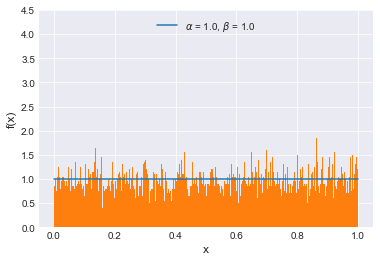

In [33]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 1, 200)
a = 1.
b = 1.
pdf = stats.beta.pdf(x, a, b)
plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.hist(psample1['phi'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

In [34]:
np.min(psample1['phi']), np.max(psample1['phi'])

(0.00025045927160058287, 0.9996948851151624)

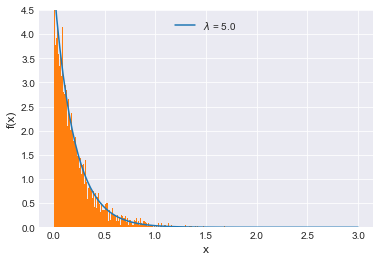

In [35]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 3, 100)
lam = 5.
pdf = stats.expon.pdf(x, scale=1.0/lam)
plt.plot(x, pdf, label=r'$\lambda$ = {}'.format(lam))
plt.hist(psample1['logkappa'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

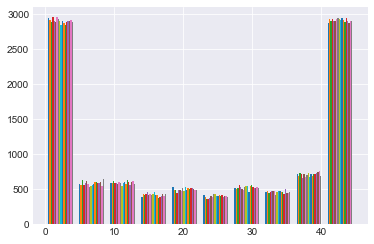

In [36]:
plt.hist(psample1['y']);

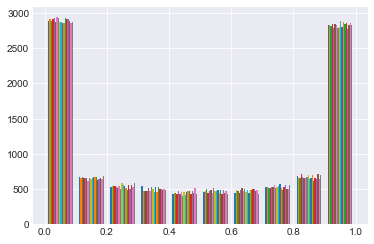

In [37]:
plt.hist(psample1['thetas']);

In [38]:
psample1['thetas'].mean(axis=0) * at_bats

array([22.34161287, 22.29305538, 22.30000507, 22.33143704, 22.25281348,
       22.47452511, 22.34152065, 22.21904657, 22.29503641, 22.54440724,
       22.3284237 , 22.57986049, 22.19121857, 22.37684348, 22.24344478,
       22.38825556, 22.4451233 , 22.35289227])

In [39]:
psample1['y'].mean(axis=0)

array([22.4298, 22.516 , 22.4241, 22.4939, 22.4404, 22.5317, 22.4264,
       22.5743, 22.7293, 22.6308, 22.6162, 22.5406, 22.5673, 22.6015,
       22.6106, 22.4086, 22.5985, 22.3958])

In [40]:
vars = set(model.named_vars.keys())

In [41]:
names = pm.util.get_default_varnames(model.named_vars, include_transformed=False)
# draw_values fails with auto-transformed variables. transform them later!

In [42]:
print([name for name in names])

['logkappa', 'phi', 'thetas', 'y', 'kappa']


In [43]:
values = draw_values([model[name] for name in names], size=1000)

In [44]:
draw_values([model['phi']], size=1000)

[array([4.45345577e-01, 8.57132772e-01, 7.93674564e-01, 8.44393210e-01,
        9.02885347e-01, 3.50512151e-01, 2.63597432e-01, 7.77787156e-01,
        3.84108874e-02, 4.98823561e-01, 1.47523552e-01, 7.39648582e-03,
        7.23120475e-01, 9.21926799e-01, 8.76623194e-01, 8.31306184e-02,
        7.15444304e-01, 1.36200070e-01, 5.52101798e-01, 8.81249748e-01,
        5.25546417e-01, 9.93986775e-01, 7.49856967e-01, 9.25691429e-01,
        9.00209729e-01, 6.72740191e-01, 4.00746768e-01, 5.31340972e-01,
        3.73688973e-01, 7.07645557e-02, 6.71571621e-01, 4.98975753e-01,
        6.23271780e-01, 4.92184428e-03, 1.28230401e-01, 4.73349221e-01,
        4.86877198e-01, 7.13489790e-03, 8.87709595e-01, 6.13814999e-01,
        7.43819814e-01, 9.02489536e-02, 4.55594551e-01, 9.12812729e-01,
        1.22921086e-01, 1.46528816e-02, 5.65401768e-01, 5.14933128e-01,
        2.41039921e-01, 4.17792448e-01, 9.72369431e-01, 1.95696920e-01,
        4.14433506e-01, 4.70519720e-01, 5.59995022e-01, 6.717203

### sample from prior with sampler

In [45]:
with pm.Model() as model_:
    phi = pm.Beta('phi', alpha=1., beta=1.)

    kappa_log = pm.Exponential('logkappa', lam=5.)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta('thetas', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=N)

    y = pm.Binomial('y', n=at_bats, p=thetas, shape=N)

In [27]:
%%time
with model_:
    psample2 = pm.sample(10000, tune=5000, chains=1, step=pm.Metropolis())

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [y]
>Metropolis: [thetas_logodds__]
>Metropolis: [logkappa_log__]
>Metropolis: [phi_logodds__]
100%|██████████| 15000/15000 [00:14<00:00, 1006.66it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


CPU times: user 17.5 s, sys: 402 ms, total: 17.9 s
Wall time: 17.8 s


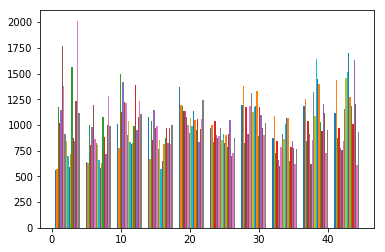

In [28]:
plt.hist(psample2['y']);

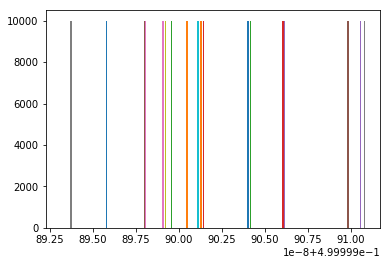

In [29]:
plt.hist(psample2['thetas']);

In [11]:
psample1['thetas'].mean(axis=0) * at_bats

array([29.17537646, 29.19002776, 29.15011068, 29.14314161, 29.14502391,
       29.16139058, 29.1881896 , 29.17654139, 29.19103725, 29.18007975,
       29.16310776, 29.13774703, 29.19948359, 29.15999634, 29.18637443,
       29.19694937, 29.16231964, 29.17803222])

In [12]:
psample1['y'].mean(axis=0)

array([27.9016, 27.851 , 27.989 , 27.8241, 27.801 , 28.0052, 27.8268,
       28.0808, 27.9234, 27.8336, 28.078 , 27.8091, 27.8389, 28.0057,
       27.9665, 27.8917, 27.9447, 27.8897])